#### Average Bubble Profile

In [2]:
import numpy as np
import math
import matplotlib
#matplotlib.rcParams.update({'font.size': 12})
from matplotlib import gridspec
import matplotlib.pyplot as plt
from collections import deque
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
import scipy.interpolate as intp
import statistics as stat
import random
from functools import partial
from operator import eq
from itertools import zip_longest, compress, count, islice, groupby, cycle
#from labellines import labelLine, labelLines
import os
import scipy.ndimage
from scipy.ndimage import gaussian_filter, gaussian_filter1d

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 4096
nSims = 1
lSims = 0

nu = 2.*10**(-3)
lamb = 6; print('lamb = ', lamb)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 2 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi0 = 2. * np.pi / 7.; print('phi0 = ', phi0)

alpha = 8.
nCols = 1
phi_initial = np.pi
mask = 4*phi_initial

############################################################
nyq = nLat//2+1
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha
light_cone = dtout/dx

lamb =  6
m2eff =  0.28
lenLat =  1581.1388300841897
phi0 =  0.8975979010256552


In [4]:
titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
sim_location = lambda sim: '/gpfs/dpirvu/sims/x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'

def extract_data(nL, sim):
    data = np.genfromtxt(sim_location(sim))
#    simulation = [np.reshape(data[:,col], (len(data)//nL, nL)) for col in range(nCols)]
    simulation = np.reshape(data, (len(data)//nL, nL))
    return np.asarray(simulation)

def triage(sim):
    simulation = extract_data(nLat, sim)
    outcome = check_decay(simulation)
    if outcome == 1:
        simulation = 2.*phi_initial - simulation
    if outcome != 2:
        return np.asarray(simulation)

def check_decay(simulation):
    T, N = np.shape(simulation)
    right_phi = np.count_nonzero(simulation[-1] > phi_initial+np.pi)
    left_phi = np.count_nonzero(simulation[-1] < phi_initial-np.pi)
    if right_phi>0 and left_phi==0: return 0
    elif left_phi>0 and right_phi==0: return 1
    else: return 2

In [5]:
all_data = np.asarray([triage(sim) for sim in range(lSims, nSims, 1)])

In [6]:
if False:
    instanton_location = '/home/dpirvu/inst/instantons/dev/thin_wall_instanton_sim.dat'
    a = np.genfromtxt(instanton_location)
    coleman_profile = np.pi+a[:,0]
    peaks, _ = scs.find_peaks(coleman_profile)
    fwhm, height, left_ips, right_ips = scs.peak_widths(coleman_profile, peaks, rel_height=0.5)
    filter_size = max(fwhm)/2.; print('filter_size = ', filter_size)
    radius_Coleman_bubble = filter_size*dx

    plt.plot(np.arange(len(coleman_profile)), coleman_profile)
    plt.plot(peaks, coleman_profile[peaks], "x")
    [plt.hlines(height[i], left_ips[i], right_ips[i], color="C2") for i in range(len(fwhm))]
    plt.xlabel(r'$r_{\rm E}$')
    plt.ylabel(r'$\phi$')

In [7]:
lattice = np.arange(nLat)
xlist = lattice * dx
klist = np.roll((lattice - nLat)*dk, nLat//2)

# Field power spectrum
norm = 1./ phi0 / np.sqrt(2. * lenLat)
w2free = lambda m2: klist**2. + m2

# Free field (constant mass term) field modes \phi_k
free_eigenbasis = norm / w2free(m2eff)**0.25
free_eigenbasis[klist==0]=0.

#Power spectrum of field in the BH background
pspec = np.abs(free_eigenbasis)**2
fluct_variance = np.sum(pspec)
fluct_stdev = np.sqrt(fluct_variance)

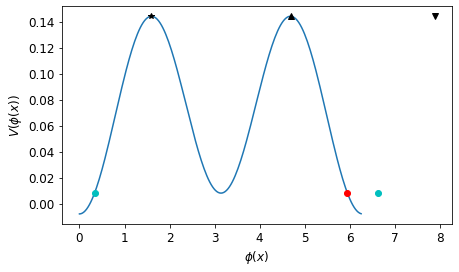

In [8]:
def V(phi):
    return ( -np.cos(phi) + 0.5 * lamb**2. * np.sin(phi)**2. ) * 4. * nu
def dV(phi):
    return ( np.sin(phi) + 0.5 * lamb**2. * np.sin(2.*phi) ) * 4. * nu

right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[0, np.pi], method='bounded')
next_right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded')

def F(x):
    return V(x) - V(phi_initial)
phi_upper_bound = sco.fsolve(F, 5.5)[0]
phi_lower_bound = sco.fsolve(F, 0.5)[0]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(7, 4))
plt.plot([i for i in np.arange(0, 2.*np.pi, phi_initial/100)], [V(i) for i in np.arange(0, 2.*np.pi, phi_initial/100)])
plt.plot(phi_upper_bound, V(phi_upper_bound), 'ro')
plt.plot(phi_lower_bound, V(phi_lower_bound), 'co')
plt.plot(phi_lower_bound+2.*np.pi, V(phi_lower_bound+2.*np.pi), 'co')

plt.plot(left_phi_at_V_max.x, V(left_phi_at_V_max.x), 'k*')
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x), 'k^')
plt.plot(next_right_phi_at_V_max.x, V(next_right_phi_at_V_max.x), 'kv')
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$'); plt.show()

### VISUALISING SIMULATION DATA

In [9]:
def add_mask(field_slice, mask):
    """ Sets to zero all array elements greater in abs value than some threshold. """
    boolarr = np.abs(field_slice) < mask
    return field_slice * boolarr

def find_slice_peaks(field_slice, peak_threshold):
    """ Finds x coordinate of peaks with height above some threshold. """
    peak_coord = scs.find_peaks(field_slice, height = peak_threshold)[0]
    if field_slice[-1] > peak_threshold and field_slice[0] > peak_threshold and field_slice[-1] != field_slice[0]:
        if field_slice[0] > field_slice[-1] and field_slice[0] > field_slice[1]:
            peak_coord.append(0)
        elif field_slice[0] < field_slice[-1] and field_slice[-1] > field_slice[-2]:
            peak_coord.append(len(field_slice)-1) # this minds potential boundary discontinuities
    max_peak = np.max(field_slice[peak_coord])
    return peak_coord, field_slice.tolist().index(max_peak)

def truncateNum(num, decimal_places):
    StrNum = str(num)
    p = StrNum.find(".") + 1 + decimal_places
    return float(StrNum[0:p])

def bubble_counts_at_time(bubble):
    T, N = np.shape(bubble)
    bubble_counts = np.count_nonzero(bubble > right_phi_at_V_max.x, axis=1)
    return bubble_counts

def remove_collisions(bubble):
    T, N = np.shape(bubble[0])
    bubble_counts = np.count_nonzero(bubble[0] > next_right_phi_at_V_max.x+np.pi, axis=1)
    tdecap = np.nonzero(bubble_counts)[0][0]
    tdecap = min(tdecap - 300, T-1)
    return bubble[:, :tdecap]

def time_at_size(bubble_counts, size):
    diffs = bubble_counts - size
    return np.abs(diffs).argmin()

def decap_bubble(bubble):
    T, N = np.shape(bubble)
    counts = bubble_counts_at_time(bubble)
    list_frac = np.asarray([time_at_size(counts, i) for i in np.arange(N)])
    tcut = list_frac[list_frac != list_frac[-1]][-1]
    return int(np.round(tcut))

def amputate_bubble(bubble, window):
    T, N = np.shape(bubble[0])
    t_centre, x_centre = find_nucleation_center(bubble[0])
    tdecap = min(T-1, t_centre+2*window)
    slice = np.abs(bubble[0, tdecap]-phi_initial) + phi_initial
    extent = np.where(slice > right_phi_at_V_max.x)[0]
    xmin = max(extent[0] - window, 0)
    xmax = min(extent[-1] + window, N-1)

    bubble = bubble[:, :tdecap, xmin:xmax]
    T, N = np.shape(bubble[0])
    t_centre, x_centre = find_nucleation_center(bubble[0])
    bubble = np.roll(bubble[:, :], N//2-x_centre)
    return bubble

def find_nucleation_center(bubble):
    T, N = np.shape(bubble)
    bubble_counts = np.count_nonzero(bubble > right_phi_at_V_max.x, axis=0)
    x0 = np.argmax(bubble_counts)
    refl_bubble = np.abs(bubble-phi_initial) + phi_initial
    bubble_counts = np.count_nonzero(refl_bubble > right_phi_at_V_max.x, axis=1)
    # this would better be the Coleman radius or something
#    min_size  =(max(bubble_counts)-min(bubble_counts))*20./100. 
    min_size = 200
    diffs = bubble_counts - min_size
    t0 = np.abs(diffs).argmin()
    return t0, x0

def centre_bubble(bubble):
    T, N = np.shape(bubble[0])
    t_centre, x_centre = find_nucleation_center(bubble[0])
    bubble = np.roll(bubble, N//2-x_centre, axis=-1)
    bubble_counts = np.count_nonzero(bubble[0] == phi_initial, axis=0)
    xright = np.argwhere(bubble_counts[N//2:]==T).flatten()
    xleft = np.argwhere(bubble_counts[:N//2]==T).flatten()
    xmax = np.min(np.append(xright+N//2,N-1))
    xmin = np.max(np.append(xleft,0))
    return bubble[:, :, xmin:xmax]

def direction_bubble(bubble):
    T, N = np.shape(bubble[0])
    refl_bubble = np.abs(bubble[0]-phi_initial) + phi_initial
    bubble_counts = np.count_nonzero((refl_bubble > phi_initial+fluct_stdev) & (refl_bubble < right_phi_at_V_max.x), axis=0)
    xmax = np.argmax(bubble_counts)
    countmax = bubble_counts[xmax]
    if np.mean(bubble_counts[:xmax]) > np.mean(bubble_counts[xmax:]):
        return +1. #right moving COM (i.e. hyperbolic wall trajectory is on the left hand side)
    else:
        return -1.

def multiply_bubble(bubble, dir, fold):
    T, N = np.shape(bubble[0])
    bubble = [np.tile(bubble[col], fold) for col in range(len(bubble))] # multiplies bubbles so tail is kept without pbc
    TT, NN = np.shape(bubble[0])
    for t in range(TT):
        a, b = int((TT-t)*light_cone) + N - 200, int((TT-t)*light_cone/2) - N//4
        x1, x2 = np.arange(a, NN), np.arange(b)
        if dir > 0:
            x1, x2 = x1 - a, x2 - (b-NN)
        for x in np.append(x1, x2):
            if 0 <= x < NN:
                bubble[0][t][x] = phi_initial
    return np.asarray(bubble)

In [10]:
#normal = [phi_initial, np.mean([sim[1][0] for sim in all_data]), np.mean([sim[2][0] for sim in all_data]), V(phi_initial), np.mean([0.5*sim[1][0]**2 for sim in all_data])]
normal = [phi_initial, 0, 0, V(phi_initial), 0]

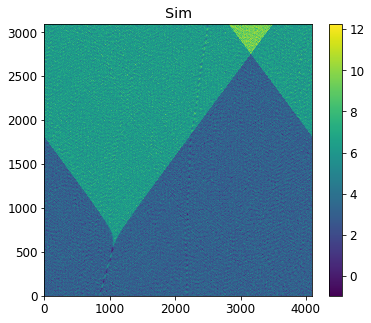

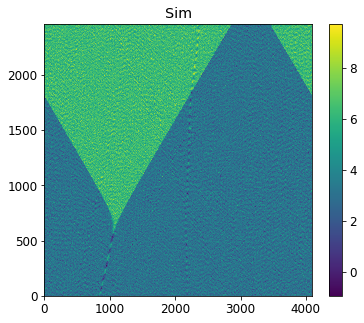

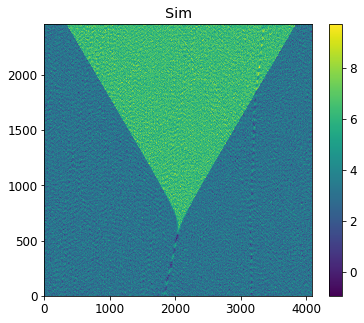

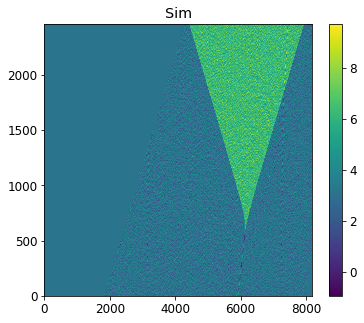

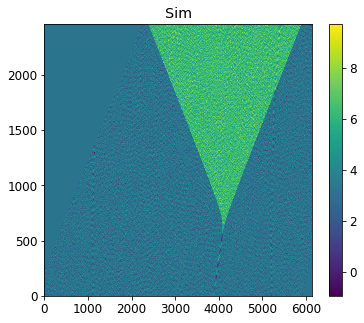

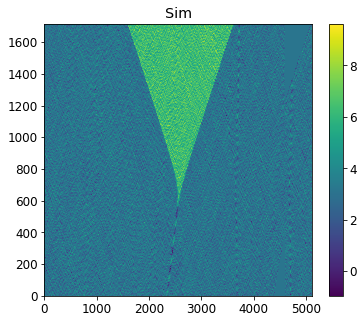

In [11]:
def simple_imshow(simulation, title='Sim'):
    fig, ax0 = plt.subplots(1, 1, figsize=(6,5))
    im0 = plt.imshow(simulation, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax0)
    ax0.set_title(title); plt.show()
    return

col = 0
simulation = all_data
simple_imshow(simulation[col])

simulation = remove_collisions(simulation)
simple_imshow(simulation[col])

simulation = centre_bubble(simulation)
simple_imshow(simulation[col])

dir = direction_bubble(simulation)
simulation = multiply_bubble(simulation, dir, 2)
simple_imshow(simulation[col])

simulation = centre_bubble(simulation)
simple_imshow(simulation[col])

simulation = amputate_bubble(simulation, 500)
simple_imshow(simulation[col])

In [85]:
def tanh(x, r0L, r0R, dr, vL, vR):
    wL, wR = dr/gamma(vL), dr/gamma(vR)
    return ( np.tanh( (x - r0L)/wL ) + np.tanh( (r0R - x)/wR ) ) * np.pi/2 + np.pi

def tanh_fit(bubble_slice, axis, prior):
    bounds = ((axis[0], 0, 0, 0, 0), (0, axis[-1], axis[-1], 1, 1))
#    plt.plot(axis, bubble_slice, 'r-')
    tanfit, _ = sco.curve_fit(tanh, axis, bubble_slice, p0=prior, bounds=bounds)
#    plt.plot(axis, tanh(axis, *tanfit), 'g-')
#    plt.show()
    return tanfit

hyperbola1 = lambda t, a, b, c: np.sqrt(c + (t - b)**2) + a
hyperbola2 = lambda t, d, e, f: - np.sqrt(f + (t - e)**2) + d

def hypfit(dir, tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    if dir > 0:
        f1, f2 = hyperbola1, hyperbola2
    else:
        f1, f2 = hyperbola2, hyperbola1
    
    try:
        fit1, _ = sco.curve_fit(f1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
        fit2, _ = sco.curve_fit(f2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        traj1, traj2 = f1(tt, *fit1), f2(tt, *fit2)
    #    print('hyperbolic trajectories fit: ', fit1, fit2)
    #    plt.plot(rr, tt, 'g-', qq, tt, 'r-', traj1, tt, 'y:', traj2, tt, 'b:') # plot the equation using the fitted parameters
        return tt, traj1, traj2
    except:
        return False

def get_velocities(tt, rrwallfit, llwallfit):
    # wall travelling along with the com
    uu = np.gradient(rrwallfit)
    # wall travelling against the com
    vv = np.gradient(llwallfit)
    uu[uu>1] = np.sign(uu[uu>1])*0.999
    vv[vv>1] = np.sign(vv[vv>1])*0.999
    uu[np.isnan(uu)]= -np.sign(vv[-1])*0.999
    vv[np.isnan(vv)]= -np.sign(uu[-1])*0.999

    # centre of mass velocity
    aa = ( 1 + uu*vv - np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / ( uu + vv)
    # instantaneous velocity of wall
    bb = (-1 + uu*vv + np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / (-uu + vv)
    return uu, vv, aa, bb

def velocity(simulation, dir, bool, step, thresh=right_phi_at_V_max.x, window=100):
    if step < 10:
        simulation = amputate_bubble(simulation, 5*window)
        simulation = simulation[0]
        t_centre, x_centre = find_nucleation_center(simulation)
        T, N = np.shape(simulation)
        Tcap = min(T-1, t_centre+500)
    else:
        simulation = simulation[0]
        t_centre, x_centre = find_nucleation_center(simulation)
        T, N = np.shape(simulation)
        Tcap = T-1
    slice0 = np.argwhere(simulation[Tcap] > phi_initial+np.pi).flatten()
    if len(slice0) == 0:
        print('Error: no nucleation detected.')
        return None, None
    xmin0 = max(0, slice0[0] - window)
    xmax0 = min(N-1, slice0[-1] + window)
    target0 = int(np.mean((xmin0, xmax0)))
    data_list = [np.asarray([target0, xmin0-target0, xmax0-target0, Tcap])]
#    data_list = [np.asarray([N//2, -N//2, N-1-N//2, Tcap])]

    prior, err = None, 0
    for t in range(Tcap-1, 0, -1):
        xmin = int(max(0, data_list[-1][0] + data_list[-1][1] - window))
        xmax = int(min(N-1, data_list[-1][0] + data_list[-1][2] + window))
        coord_list = np.arange(xmin, xmax+1)
        target = int(np.mean((xmin, xmax)))
        slice = simulation[t, coord_list]
        if len(slice[slice>thresh]) == 0 or err > 10:
            break
        try:
            r0L, r0R, dr, vL, vR = tanh_fit(slice, coord_list-target, prior)
            prior = r0L, r0R, dr, vL, vR
            data_list.append(np.asarray([target, r0L, r0R, t]))
        except:
            err += 1

    data_list = np.asarray(data_list[::-1])[:-1]
    targets, r0Ls, r0Rs, time_list = data_list[:,0], data_list[:,1], data_list[:,2], data_list[:,3]
    # direction of bubble gives which wall travels along with COM and which against
    if dir > 0:
        rr, ll = targets + r0Rs, targets + r0Ls
    else:
        rr, ll = targets + r0Ls, targets + r0Rs

    # get velocities from derivative of best fit to wall trajectory
    tt_copy, rr_copy, ll_copy = time_list, rr, ll
    loop, trunc = True, 0
    while loop and trunc < 100:
        # try to fit walls
        hyperbolae = hypfit(dir, tt_copy, rr_copy, ll_copy)
        if hyperbolae is False:
            # if fit fails, shorten walls
            trunc += 2
            tt_copy, rr_copy, ll_copy = tt_copy[trunc:], rr_copy[trunc:], ll_copy[trunc:]
        else:
            ttwallfit, rrwallfit, llwallfit = hyperbolae
            uu,vv,aa,bb = get_velocities(ttwallfit, rrwallfit, llwallfit)
            loop = False

    if len(tt_copy) == 0:
        print('Error: no hyperbolic fit found. tmin, tmax', time_list[0], time_list[-1])
        return None, None

    infl_point = np.argmin(np.abs(vv))
    if bool:
        fig, [ax0, ax1] = plt.subplots(1, 2, figsize = (15, 4))
        ax0.plot(rr, time_list, 'b', ll, time_list, 'y', linewidth='3')
        ax0.plot(rrwallfit, ttwallfit, 'r:', llwallfit, ttwallfit, 'r:', linewidth='3')
        ax0.set_xlabel('x'); ax0.set_ylabel('t')

        ax1.plot(ttwallfit, uu, 'b:', ttwallfit, vv, 'y:', ttwallfit[infl_point], vv[infl_point], 'yo')
        ax1.plot(ttwallfit, aa, 'r', label=r'v COM')
        ax1.plot(ttwallfit, bb, 'g', label=r'v walls')
        ax1.axhline(0, color='darkgray', ls=':')
        ax1.set_xlabel('t'); ax1.set_ylabel('v(t)'); ax1.legend(); plt.show()
#        plt.savefig(plots_file+'velocity_profile'+str(random.randrange(100))+suffix+'.png');

#    vCOM = aa[np.nanargmin(np.abs(aa - bb))]
    vCOM = aa[np.nanargmin(np.abs(uu - vv))]
    # the larger vCOM, the larger the subsequent boosted bubble size, which takes longer to compute; so we cap it
    return np.sign(vCOM)*min(np.abs(vCOM), 0.9), ttwallfit[infl_point]

In [89]:
rapidity = lambda v: np.arctanh(v)
gamma = lambda v: ( 1. - v**2. )**(-0.5)
fold = lambda beta: 3 if np.abs(beta) > 0.8 else 2
add_velocities = lambda v1,v2: (v1 + v2) / (1. + v1*v2)
boost = lambda vCOM, ga, x, t: ga * (x + vCOM*t)

def coord_pair(t, x, vCOM, ga):
    t0 = boost(vCOM, ga, t, x)
    x0 = boost(vCOM, ga, x, t)
    return (t0, x0)

def boost_bubble(simulation, vCOM, dir, tcentre):
    T, N = np.shape(simulation[0])
    slice = simulation[0, int(tcentre)]
    refl_slice = np.abs(slice-phi_initial) + phi_initial
    xcentre = np.mean(np.where(refl_slice > phi_initial+np.pi))

    t0, x0 = tcentre, xcentre
    t = np.linspace(-t0, T-1-t0, T)
    x = np.linspace(-x0, N-1-x0, N)
    tt, xx = np.meshgrid(t, x, sparse=True)

    # apply coordinate transformation onto grid
    ga = gamma(vCOM)
    tt_lensed, xx_lensed = coord_pair(tt, xx, vCOM, ga)
#    deltaT, deltaX = boost(vCOM, ga, t0, x0) - t0 + np.abs(np.abs(t0)-np.abs(T/2.)), boost(vCOM, ga, x0, t0) - x0 - np.abs(x0-N/2.)
    deltaT, deltaX = boost(vCOM, ga, t0, x0) - 21.*t0/20., boost(vCOM, ga, x0, t0) - x0 - np.abs(x0-N/2.)
    tt_lensed, xx_lensed = tt_lensed + deltaT, xx_lensed + deltaX

#    print('Boost centre t0, x0: ', t0, x0)
#    plt.plot(t, t, 'b-', t, tt_lensed[0,:], 'g-'); plt.show()
#    plt.plot(x, x, 'b-', x, xx_lensed[:,0], 'g-'); plt.show()

    for col, element in enumerate(simulation):
        # interpolate image onto transformed coordinates
        g = intp.interp2d(tt_lensed[0,:], xx_lensed[:,0], element.T, kind = 'cubic')
        # evaluate function on the mesh
        simulation[col] = g(t, x).T
    return simulation

Starting simulation 0
(1, 3096, 4096)
Step  1  done, vtot =  0.35419796843480833 last boost v =  0.35419796843480833
Step  2  done, vtot =  0.6292089130370478 last boost v =  0.3538777358985721
Step  3  done, vtot =  0.8188461358280029 last boost v =  0.39118629279229217
Step  4  done, vtot =  0.917020898347806 last boost v =  0.3941163224626134
Step  5  done, vtot =  0.9633882907406106 last boost v =  0.397823053027995
Step  6  done, vtot =  0.9839502611118937 last boost v =  0.3948618050957261
Step  7  done, vtot =  0.9929686564536562 last boost v =  0.3926464889995923
Step  8  done, vtot =  0.9969242634408686 last boost v =  0.3922091326419327
Step  9  done, vtot =  0.9986619529176292 last boost v =  0.39406354701714025


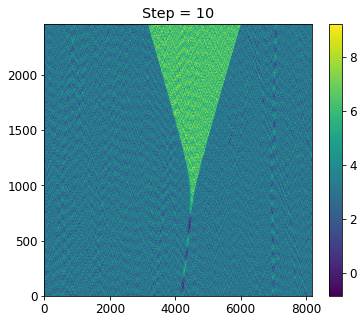

Step  10  done, vtot =  0.9994276055873371 last boost v =  0.4009333668817559
Step  11  done, vtot =  0.9997571644079657 last boost v =  0.40432150252434873
Step  12  done, vtot =  0.9998987642345074 last boost v =  0.41157144112986016
Step  13  done, vtot =  0.9999579975847502 last boost v =  0.4135427326719623
Step  14  done, vtot =  0.9999823898504765 last boost v =  0.4091850179617205
Step  15  done, vtot =  0.9999925561601954 last boost v =  0.40577820873212456
Step  16  done, vtot =  0.9999969001224454 last boost v =  0.4119962256930749
Step  17  done, vtot =  0.9999986749153358 last boost v =  0.4010869359208169
Step  18  done, vtot =  0.9999994277450234 last boost v =  0.396781879312038
Step  19  done, vtot =  0.9999997527804715 last boost v =  0.3966389465208792


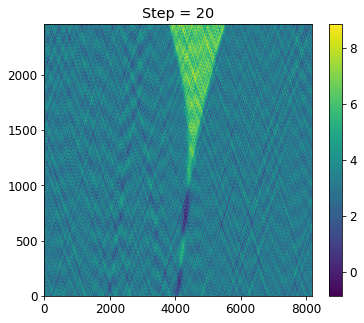

Step  20  done, vtot =  0.9999998926836416 last boost v =  0.3946093633805753
Step  21  done, vtot =  0.9999999535862988 last boost v =  0.3961662358099256
Step  22  done, vtot =  0.9999999806024548 last boost v =  0.4105097199231837
Step  23  done, vtot =  0.9999999919286928 last boost v =  0.4123302173107151
Step  24  done, vtot =  0.9999999954296731 last boost v =  0.2769404790889295
Step  25  done, vtot =  0.9999999973546845 last boost v =  0.266783110138985
Step  26  done, vtot =  0.999999998448862 last boost v =  0.2607386549075255
Step  27  done, vtot =  0.9999999990831474 last boost v =  0.2570048239359573
Step  28  done, vtot =  0.9999999994545729 last boost v =  0.25400431124750533
Step  29  done, vtot =  0.9999999996749097 last boost v =  0.2531100587059606


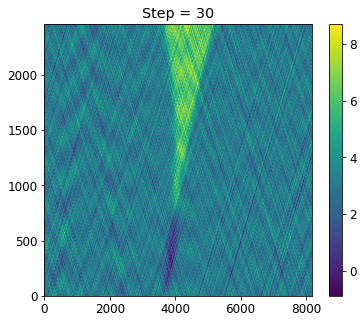

Step  30  done, vtot =  0.9999999998063097 last boost v =  0.25328629820588994
Step  31  done, vtot =  0.9999999998846253 last boost v =  0.2533953610389788
Step  32  done, vtot =  0.9999999999310786 last boost v =  0.2520578232374521
Step  33  done, vtot =  0.9999999999586315 last boost v =  0.24982282953950485
Step  34  done, vtot =  0.9999999999750003 last boost v =  0.24663701539132712
Step  35  done, vtot =  0.9999999999848569 last boost v =  0.24554158876820525
Step  36  done, vtot =  0.9999999999908151 last boost v =  0.24491403501666195
Step  37  done, vtot =  0.9999999999944152 last boost v =  0.2437453465112602
Step  38  done, vtot =  0.9999999999965792 last boost v =  0.24028990387393856
Step  39  done, vtot =  0.9999999999978926 last boost v =  0.23756399346880297


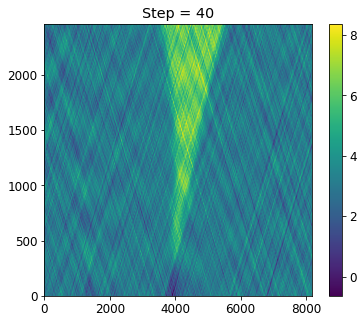

Step  40  done, vtot =  0.9999999999986942 last boost v =  0.23477498587340329
Step  41  done, vtot =  0.9999999999991884 last boost v =  0.23338575337747294
Step  42  done, vtot =  0.9999999999994942 last boost v =  0.23210187447530986
Step  43  done, vtot =  0.9999999999996896 last boost v =  0.23955878104875214
Step  44  done, vtot =  0.9999999999998102 last boost v =  0.2408040329028284
Step  45  done, vtot =  0.9999999999998836 last boost v =  0.24038168491688405
Step  46  done, vtot =  0.9999999999999287 last boost v =  0.24028716599667369
Step  47  done, vtot =  0.9999999999999567 last boost v =  0.244663523336554
Step  48  done, vtot =  0.9999999999999741 last boost v =  0.25097631883976107
Step  49  done, vtot =  0.9999999999999846 last boost v =  0.25399613663003456


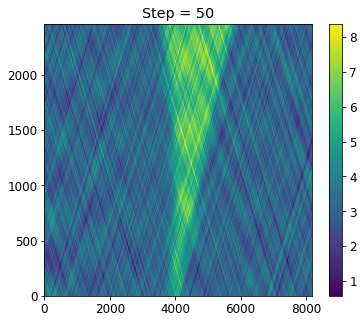

Step  50  done, vtot =  0.9999999999999908 last boost v =  0.2549768460374328
Step  51  done, vtot =  0.9999999999999947 last boost v =  0.25615536348715146
Step  52  done, vtot =  0.9999999999999968 last boost v =  0.2570725360219957
Stopped. Sim 0 total steps  52


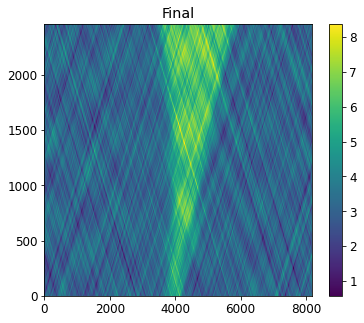

In [91]:
thresh = right_phi_at_V_max.x
window = 100
saveF = True

step = 0
for sim, simulation in enumerate([all_data]):
        print('Starting simulation', sim)
        print(np.shape(simulation))
 
        simulation = remove_collisions(simulation)
        simulation = centre_bubble(simulation)
        dir = direction_bubble(simulation)
        beta, tcentre = velocity(simulation, dir, False, step, thresh, window)
        if beta == None:
            print('Skipped.')
            continue
        bubble = multiply_bubble(simulation, dir, fold(beta))

        vtotal, bool1 = 0, True
        while np.abs(beta) > 0.1:
            bool2 = True
            step += 1

            bubble = boost_bubble(bubble, beta, dir, tcentre)
            if step%10==0:
                simple_imshow(bubble[0], 'Step = '+str(step))

            prebeta = beta
            vtotal = add_velocities(vtotal, prebeta)
            print('Step ', step,' done, vtot = ', vtotal, 'last boost v = ', prebeta)
            beta, tcentre = velocity(bubble, dir, False, step, thresh, window)
            if beta == None:
                'Stopped here.'
                if prebeta > 0.5:
                    bool1 = False # bubble was still relativistc on last step
                break

        print('Stopped. Sim', sim, 'total steps ', step)
        if bool1 and saveF:
#            min_bubble = amputate_bubble(bubble, window)
            simple_imshow(bubble[0], 'Final')
#            np.save(bubbles_at_rest_file(sims_to_keep[sim]), [min_bubble, vtotal])

### Average bubble

In [ ]:
 def cut_out_coordinates(bubble0):
    T, N = len(bubble0), len(bubble0[0])
    limit = np.floor(phi_upper_bound)
    size = 150 # do not change

    tmin = T-1
    for t in range(T):
        slice = gaussian_filter1d(bubble0[t], sigma=1)
        right_phi = [x for x in range(N-1) if (slice[x] >= limit and slice[x+1] >= limit)]
        if len(right_phi) >= size:
            tmin = t
            break
    if tmin == T-1:
        return None
    xcen = int(np.round(np.nanmean(right_phi)))
    xcen_list = [np.round(np.nanmean([x for x in range(N) if bubble0[t][x] >= limit])) for t in range(tmin-50,tmin,2)]
    if stat.stdev(xcen_list) > 90:
        return None

#    fig = plt.figure(figsize=(4,4))
#    plt.plot(xcen, tmin, 'ro')
#    plt.imshow(bubble, aspect='auto', interpolation='none', origin='lower')
#    plt.show()
    ex1, ex2, ex3, ex4 = np.arange(tmin, 0, -1), np.arange(tmin, T), np.arange(xcen, 0, -1), np.arange(xcen, N)

    if len(ex1) > 2000: ex1 = ex1[:2000]
    if len(ex2) > 1000: ex2 = ex2[:1000]
    if len(ex3) > 1000: ex3 = ex3[:1000]
    if len(ex4) > 1000: ex4 = ex4[:1000]    
    return ex1, ex2, ex3, ex4

def stack_bubbles(bubble_data):
    extent_list, bad_bubbles = [], []

    for sim in range(len(bubble_data)):
        coords = cut_out_coordinates(bubble_data[sim][0])
        if coords is not None:
            extent_list.append(coords)
        else:
            bad_bubbles.append(sim)

    extent_list = np.asarray(extent_list)
    print('bad bubbles', bad_bubbles)

    bubble_data = [bubble_data[i] for i in range(len(bubble_data)) if i not in bad_bubbles]
    for sim in range(len(bubble_data)):
        bubble_data[sim].append([0.5*np.asarray(i)**2 for i in bubble_data[sim][1]])
    nCols = len(bubble_data[0])

    uper_right_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,0][sim]] for x in extent_list[:,2][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    upper_left_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,0][sim]] for x in extent_list[:,3][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    lower_right_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,1][sim]] for x in extent_list[:,2][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    lower_left_bubble_list = [[[[bubble_data[sim][col][t][x] for t in extent_list[:,1][sim]] for x in extent_list[:,3][sim]] for sim in range(len(bubble_data))] for col in range(nCols)]
    return [uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list], bad_bubbles

def average_bubble_func(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)
    print(nCols)

    av_mat, av_err_mat = [], []
    for col in range(nCols):
        average_matrix, average_error_matrix = [[],[],[],[]], [[],[],[],[]]
        coord_lists = [uper_right_bubble_list[col], upper_left_bubble_list[col], lower_right_bubble_list[col], lower_left_bubble_list[col]]

        for i in range(4): #for each quadrant
            max_lines, max_cols = 0, 0
            for simulation in coord_lists[i]:
                if len(simulation) > max_lines:
                    max_lines = len(simulation)
                if len(simulation[0]) > max_cols:
                    max_cols = len(simulation[0])

            for line in range(max_lines):
                average_matrix[i].append([normal[col] for nn in range(max_cols)])
                average_error_matrix[i].append([0. for nn in range(max_cols)])

            for num_line in range(max_lines):
                for num_col in range(max_cols):
                    meas = []
                    for simulation in coord_lists[i]:
                        if len(simulation) > num_line and len(simulation[0]) > num_col:
                            meas.append(simulation[num_line][num_col])

                    average_matrix[i][num_line][num_col] = np.mean(meas)
                    if len(meas) >= 2:
                        average_error_matrix[i][num_line][num_col] = stat.stdev(meas)/len(meas)
        av_mat.append(average_matrix)
        av_err_mat.append(average_error_matrix)

    whole_bubbles = []
    for av_bub in [av_mat, av_err_mat]:
        whole_bubbles.append([])
        for col in range(nCols):
            top = np.concatenate((np.flip(np.asarray(np.flip(av_bub[col][0],1)).transpose(),1), np.flip(np.asarray(av_bub[col][1]).transpose(),0)), axis=1)
            bottom = np.concatenate((np.flip(np.asarray(av_bub[col][2]).transpose(),1), np.flip(np.asarray(np.flip(av_bub[col][3],0)).transpose(),1)), axis=1)
            whole_bubbles[-1].append(np.concatenate((top, bottom), axis=0))
    return np.asarray(whole_bubbles)

def truncated_full_bubbles_stacked(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)

    whole_bubbles = []
    for sim in range(len(uper_right_bubble_list[0])):
        whole_bubbles.append([])
        for col in range(nCols):
            bub0 = uper_right_bubble_list[col][sim]
            bub1 = upper_left_bubble_list[col][sim]
            bub2 = lower_right_bubble_list[col][sim]
            bub3 = lower_left_bubble_list[col][sim]

            top = np.concatenate((np.flip(np.asarray(np.flip(bub0,1)).transpose(),1), np.flip(np.asarray(bub1).transpose(),0)), axis=1)
            bottom = np.concatenate((np.flip(np.asarray(bub2).transpose(),1), np.flip(np.asarray(np.flip(bub3,0)).transpose(),1)), axis=1)
            whole_bubbles[-1].append(np.concatenate((top, bottom), axis=0))
    return whole_bubbles

def truncated_bubbles_stacked(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)

    whole_bubbles = []
    for sim in range(len(uper_right_bubble_list[0])):
        bub0 = uper_right_bubble_list[0][sim]
        bub1 = upper_left_bubble_list[0][sim]
        bub2 = lower_right_bubble_list[0][sim]
        bub3 = lower_left_bubble_list[0][sim]

        top = np.concatenate((np.flip(np.asarray(np.flip(bub0,1)).transpose(),1), np.flip(np.asarray(bub1).transpose(),0)), axis=1)
        bottom = np.concatenate((np.flip(np.asarray(bub2).transpose(),1), np.flip(np.asarray(np.flip(bub3,0)).transpose(),1)), axis=1)
        whole_bubbles.append(np.concatenate((top, bottom), axis=0))
    return whole_bubbles

In [ ]:
bubble_list = np.asarray([np.load(bubbles_at_rest_file(sim)) for sim in range(340) if os.path.exists(bubbles_at_rest_file(sim))])
bubble_list_save, bubble_velocities = bubble_list[:,0], bubble_list[:,1]
del bubble_list

In [ ]:
#either compute average
stacked_bubble_parts, bad_bubbles = stack_bubbles(bubble_list_save)
ab, error_ab = average_bubble_func(stacked_bubble_parts)
#newfullBubbleData = truncated_full_bubbles_stacked(stacked_bubble_parts)
#newBubbleData = truncated_bubbles_stacked(stacked_bubble_parts)

np.save('/home/dpirvu/phi070_lambda15/average_bubble.npy', [ab, error_ab])
#np.save(new_bubble_data(0, 340), newBubbleData)
#np.save(new_full_bubble_data(0, 340), newfullBubbleData)

#or load it
#ab, error_ab = np.load(average_bubble(lSims, nSims))
#newBubbleData = np.load(new_bubble_data(lSims, nSims)).tolist()
#newfullBubbleData = np.load(new_full_bubble_data(lSims, nSims)).tolist()

#separate columns
bubble, mom_bubble, ge_bubble, pe_bubble, ke_bubble = ab
error_bubble, error_mom_bubble, error_ge_bubble, error_pe_bubble, error_ke_bubble = error_ab

In [ ]:
#plot average bubble, mom_bubble, ge_bubble, pe_bubble, ke_bubble
fig, ax = plt.subplots(1, len(ab), figsize=(25, 5))
for col in range(len(ab)):
    im = ax[col].imshow(ab[col], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[col])
plt.savefig(plots_file+'average_bubble'+suffix+'.png')

#plot distribution of boosts
bubble_velocities = [bubble_velocities[i] for i in range(len(bubble_velocities)) if i not in bad_bubbles]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(bubble_velocities, bins=len(bubble_velocities))
ax[1].hist([gamma(i) for i in bubble_velocities], bins=len(bubble_velocities))
ax[2].hist([rapidity(i) for i in bubble_velocities], bins=len(bubble_velocities))

[ax[i].set_ylabel('Count') for i in range(len(ax))]
ax[0].set_xlabel(r'$v$'); ax[1].set_xlabel(r'$\gamma$'); ax[2].set_xlabel(r'$w$');
plt.savefig(plots_file+'boost_distrib'+suffix+'.png');

In [ ]:
#average x bubbles at a time; save
Nbubs = len(newfullBubbleData)
step = 4
for ii in range(0, Nbubs, step):
    boolBreak = False
    qq = len(newfullBubbleData)
    stacked_bubble_parts, _ = stack_bubbles(np.asarray(newfullBubbleData)[:,:-1].tolist())
    ab, error_ab = average_bubble_func(stacked_bubble_parts)
    np.save(average_of_N_bubbles(qq), [ab, error_ab, qq])
    for jj in range(step):
        if len(newfullBubbleData) > 2:
            del newfullBubbleData[0]
        else:
            boolBreak = True
            break
    if boolBreak:
        break